In [1]:
import math
import json
import numpy as np
import matplotlib.pyplot as plt

import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe
from openrtdynamics2.ORTDtoNumpy import ORTDtoNumpy

from vehicle_lib.vehicle_lib import *
import vehicle_lib.path_transformations as pt


In [2]:
Ts = 0.01

In [3]:
# load track data
with open("track_data/simple_track.json", "r") as read_file:
    track_data = json.load(read_file)


# Create a path transformer

In [4]:
path_transform = pt.LateralPathTransformer(wheelbase=3.0)

compiling system store_input_data (level 1)... 
compiling system tracker_loop (level 3)... 
compiling system Subsystem1000 (level 2)... 
compiling system controller (level 2)... 
compiling system simulation_model (level 2)... 
compiling system process_data (level 1)... 
compiling system simulation (level 0)... 
Generated code will be written to generated/tmp1 .


# Define profiles for the lateral distance to the original path

In [5]:
def generate_lateral_profile_1(max_distance, index1, index2, length):
    # define a profile that moves the path to the side and back
    
    lateral_profile = {}
    lateral_profile['Delta_l_r']  = filtfilt(
        Ts, 
        np.concatenate((  
            
            np.zeros(index1), 
            np.ones(index2-index1)   * max_distance, 
            np.zeros(length - index2) 
            
        )),
        cutoff_frq=0.005
    )
    
    lateral_profile['Delta_l_r_dot'] = numerical_derivative(Ts, lateral_profile['Delta_l_r'])
    lateral_profile['Delta_l_r_dotdot'] = numerical_derivative(Ts, lateral_profile['Delta_l_r_dot'])

    # velocity of the vehicle
    lateral_profile['v'] = 5 * np.ones( len( lateral_profile['Delta_l_r'] ) )
    
    return lateral_profile
    
def plot_lateral_profile( lateral_profile ):
    time = make_time(Ts, lateral_profile['Delta_l_r'])
    plt.figure(figsize=(12,8), dpi=70)
    plt.plot(time, lateral_profile['Delta_l_r'] )
    plt.plot(time, lateral_profile['Delta_l_r_dot'] )
    plt.plot(time, lateral_profile['Delta_l_r_dotdot'] )
    plt.legend(['intended lateral distance', '1st-order derivative', '2nd-order derivative'])
    plt.show()

The profile for the lateral distance is:

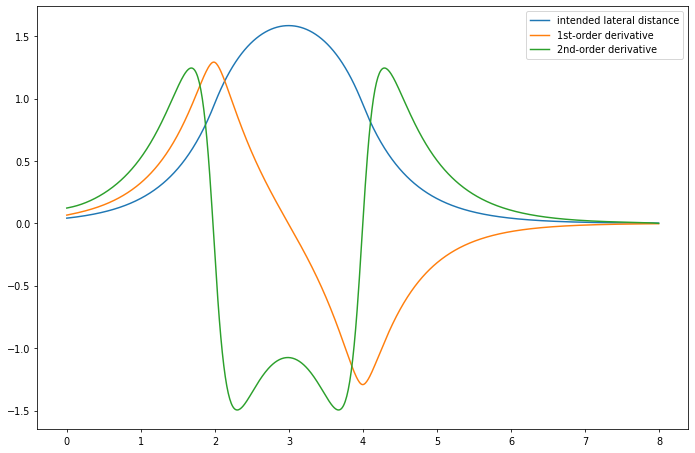

In [6]:
lateral_profile = generate_lateral_profile_1( max_distance=2, index1 = 200, index2 = 400, length = 800 )
plot_lateral_profile(lateral_profile)

# Perform the transformation

In [7]:
output_path = path_transform.run_lateral_path_transformer( track_data, lateral_profile )

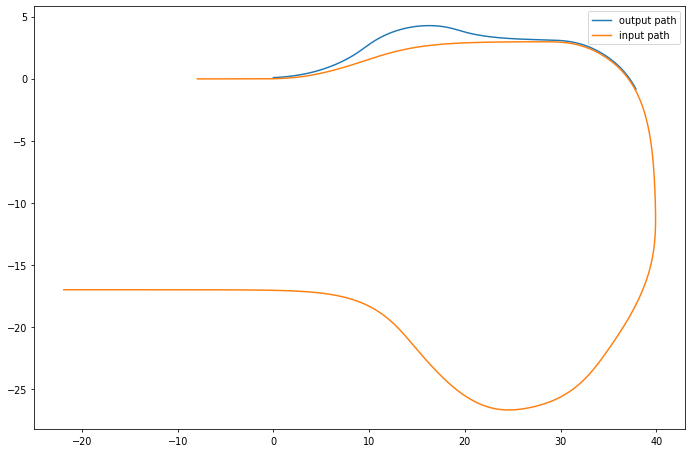

In [8]:
plt.figure(figsize=(12,8), dpi=70)
plt.plot( output_path['X'], output_path['Y']+0.1 )
plt.plot( track_data['X'], track_data['Y'] )
plt.legend(['output path', 'input path'])
plt.show()

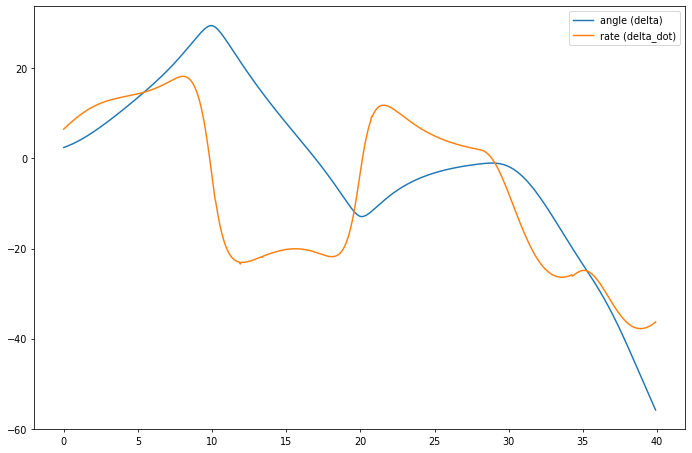

In [9]:
plot_path(output_path, show_xy=False)

# Multiple runs

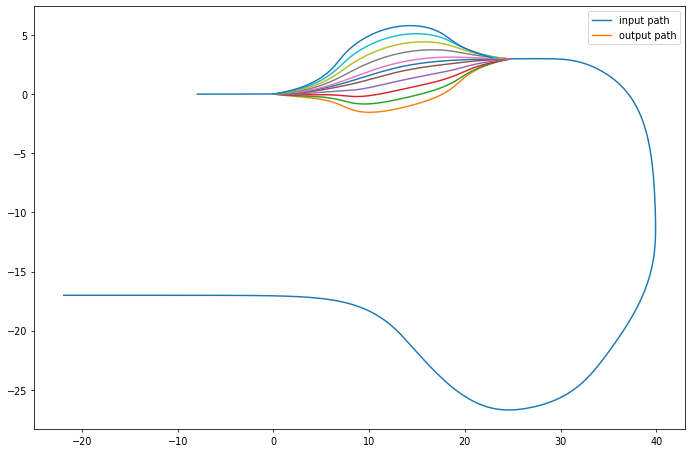

In [11]:
# compute multiple paths in a loop
output_paths = []

for max_distance in np.linspace(-4, 4, 10):

    lateral_profile = generate_lateral_profile_1( max_distance=max_distance, index1 = 150, index2 = 400, length = 500 )
    output_paths.append( path_transform.run_lateral_path_transformer( track_data, lateral_profile ) )


# plot
plt.figure(figsize=(12,8), dpi=70)
plt.plot( track_data['X'], track_data['Y'] )

for output_path in output_paths:
    plt.plot( output_path['X'], output_path['Y'] )


plt.legend(['input path', 'output path'])
plt.show()